## Random Forest

Author: Elisa Warner
Created: 4/16/2019

Purpose: Check results of SVM against stock data

Change Record:  
6/11/2019 Made Time-Cross Validation be non-overlapping  
6/13/2019 Changed Labels so they are based on de fact RUA Close, not SI. Also added Regression RF

## Confusion Table Function

In [536]:
###########################
## Create confusion table
###########################

import matplotlib
import matplotlib.pyplot as plt

def prediction_box(predictions, ground_truth):
    ## results
    result = {'tp':0, 'fp':0, 'tn':0, 'fn':0}

    for i in range(len(predictions)):
        #print(pred_test[i], y[i])
        if predictions[i] == ground_truth[i] and ground_truth[i] == 1:
            result['tp'] = result.get('tp', 0) + 1
        elif predictions[i] == ground_truth[i] and ground_truth[i] == 0:
            result['tn'] = result.get('tn', 0) + 1
        elif predictions[i] != ground_truth[i] and ground_truth[i] == 1:
            result['fn'] = result.get('fn', 0) + 1
        else:
            result['fp'] = result.get('fp', 0) + 1

    m = np.array([[result['tp'], result['fn']],[result['fp'],result['fn']]])
    fig, ax = plt.subplots()
    im = ax.imshow(m, cmap='Pastel1')
    
    for i in range(m.shape[0]):
        for j in range(m.shape[1]):
            plt.text(j, i, "{:.2f}".format(m[i,j]), ha="center", va="center")
            plt.title('Predictions for Test Set')
            ax.set_xticks([0, 1])
            ax.set_yticks([0, 1])
            ax.set_xticklabels([1, 0])
            ax.set_yticklabels([1, 0])
            plt.ylabel('Ground Truth')
            plt.xlabel('Prediction')

### Remove Missing

In [537]:
def remove_missing(df):
    for col in list(df):
        colvals = df[col].values
        new_colvals = []
        for i in range(len(colvals)):
            if colvals[i] == '.':
                print('Missing found')
                new_colvals.append(colvals[i-1])
            elif pd.isnull(colvals[i]):
                print('nan found')
                new_colvals.append(colvals[i-1])
            else:
                new_colvals.append(colvals[i])
        df[col] = new_colvals
    
    return df

In [538]:
def remove_missing_horz(df):
    new_df = pd.DataFrame()
    for i in range(df.shape[0]):
        row = list(df.iloc[i].values)

        if '.' in row:
            idx_list = [i for i in range(len(row)) if row[i] == ('.')]
            for idx in idx_list:
                row[idx] = row[idx - 1]

        idx_list = [i for i in range(len(row)) if pd.isnull(row[i]) == True]
        for idx in idx_list:
            row[idx] = row[idx - 1]
            
        new_df = new_df.append(pd.DataFrame(row).T, ignore_index = True)
    
    return new_df

## 1. Load Data

In [569]:
#!pip3 install -U scikit-learn scipy matplotlib

In [570]:
import pandas as pd
from sklearn import svm
import numpy as np

In [602]:
file1 = "./Combined_Sets_from_Revised.csv" #"Draft_Google_Shorter.csv" #Removed Missing

train_pd = pd.read_csv(file1)
print(train_pd.shape)

(7120, 423)


In [603]:
#train_pd[5902:7100] # Google Trends part

In [604]:
train_pd = train_pd[1:7070] #[5902:7100]

train = np.array(train_pd)
train.shape

(7069, 423)

In [605]:
train = train[:, :149] # drop google columns
train = pd.DataFrame(train)
train = train.dropna() # drop any nan rows
train.shape
train = np.array(train)

In [606]:
train = train[:,2:] # drop date
train

array([[1, 176.259995, 8.02, ..., 388.5, 390.4, 395.35],
       [1, 173.199997, 8.13, ..., 390.4, 395.35, 398.0],
       [1, 172.779999, 8.16, ..., 395.35, 398.0, 403.7],
       ...,
       [0, 1555.099976, 2.755, ..., 1312.95, 1322.5, 1320.75],
       [0, 1558.880005, 2.7119999999999997, ..., 1322.5, 1320.75, 1311.0],
       [0, 1573.310059, 2.753, ..., 1320.75, 1311.0, 1314.0]],
      dtype=object)

## 2. Time-Series Cross validation

In [607]:
def time_cross(array, time_shift = 0, size_train_set = 365, size_val_set = 100, set_shift = 0):
    np.random.seed(100)
    label_idx = 0

    if time_shift == 0:
        time_shift = size_train_set + size_val_set + set_shift
        
    train_size = train.shape
    j = 0
    group = 1
    end = train_size[0]
    trainDataPartition = [] # list
    valDataPartition = []

    #print(size_train_set, size_val_set, train_size[0])
    while j + (size_train_set + size_val_set + set_shift) < train_size[0]:
        trainset = []
        valset = []

        trainset = train[j:j+size_train_set, :] # array
        valset = train[j+size_train_set+1+set_shift:j+size_train_set+size_val_set+set_shift, :]

        trainDataPartition.append(trainset)
        valDataPartition.append(valset)
    
        group = group+1;
        j = j + time_shift


    # make last set -- decide if you want to throw out or adjust this set
    print('Last set:', j, j+size_train_set)
    trainset = train[j:j+size_train_set, :]
    valset = train[j+size_train_set+1+set_shift:end, :]
    #print(trainset)
    #print(valset)
    
    trainDataPartition.append(trainset)
    valDataPartition.append(valset)

    
    ### Optional: stratify
    revised_trainDataPartition = []
    revised_valDataPartition = []
    
    for i in range(len(trainDataPartition)):
        trainset = trainDataPartition[i]
        valset = valDataPartition[i] # Do the same for validation set
        
        print(trainset.shape[0], valset.shape[0])
        records = trainset[:,0] # record of labels for training set
        records_val = valset[:, 0] # record of labels for validation set
        #print(sum(records == 1), sum(records == 0))
        #print(sum(records_val == 1), sum(records_val == 0))
        
        ############ FOR TRAINING SET ################
        if sum(records == 1) == 0 or sum(records == 0) == 0:
            revised_trainDataPartition.append(np.nan)
        elif sum(records == 1) > sum(records == 0):
            while sum(records == 1) >= 1.3 * sum(records == 0):
                r = round(np.random.rand() * (trainset.shape[0]-1))
                #print(r)
                if records[r] == 1:
                    trainset = np.delete(trainset, r, 0)
                    records = np.delete(records, r)

            revised_trainDataPartition.append(trainset)
            
        else:
            while sum(records == 1) <= 1.3 * sum(records == 0):
                r = round(np.random.rand() * (trainset.shape[0]-1))
                if records[r] == 0:
                    trainset = np.delete(trainset, r, 0)
                    records = np.delete(records, r)

            revised_trainDataPartition.append(trainset)
        #print(sum(records == 1), sum(records == 0))
        
        ############## FOR VALIDATION SET ################
        if sum(records_val == 1) == 0 or sum(records_val == 0) == 0:
            revised_valDataPartition.append(np.nan)
        elif sum(records_val == 1) > sum(records_val == 0):
            while sum(records_val == 1) >= 1.3 * sum(records_val == 0):
                r = round(np.random.rand() * (valset.shape[0]-1))
                #print(r)
                if records_val[r] == 1:
                    valset = np.delete(valset, r, 0)
                    records_val = np.delete(records_val, r)
            revised_valDataPartition.append(valset)
        else:
            while sum(records_val == 1) <= 1.3 * sum(records_val == 0):
                r = round(np.random.rand() * (valset.shape[0]-1))
                if records_val[r] == 0:
                    valset = np.delete(valset, r, 0)
                    records_val = np.delete(records_val, r)

            revised_valDataPartition.append(valset)

    group = len(revised_trainDataPartition)
    group_val = len(revised_valDataPartition)
    print('Number of groups:', group, group_val)
    
    return revised_trainDataPartition, revised_valDataPartition, group

In [608]:
trainDataPartition, valDataPartition, group = time_cross(train, 0, 410, 260, 30)

Last set: 7000 7410
410 259
410 259
410 259
410 259
410 259
410 259
410 259
410 259
410 259
410 259
48 0
Number of groups: 11 11


In [609]:
t = pd.DataFrame(valDataPartition[1])
t.head(n=10)

,0,1,2,3,4,5,6,7,8,9,...,137,138,139,140,141,142,143,144,145,146
0,1,320.2,6.089,0.109487,0.565784,0.0858934,320.44,6.072,0.109337,0.565834,...,1,152.9,100.767,385.85,389.3,388.2,388.2,389.3,389.25,387.85
1,1,320.44,6.072,0.109337,0.565834,0.0859206,319.92,6.135,0.106634,0.565864,...,1,152.9,100.767,389.3,388.2,388.2,389.3,389.25,387.85,385.85
2,1,319.92,6.135,0.106634,0.565864,0.0800257,321.16,6.202,0.110136,0.566538,...,1,152.9,100.767,388.2,388.2,389.3,389.25,387.85,385.85,386.45
3,1,321.16,6.202,0.110136,0.566538,0.084929,318.78,6.257,0.107527,0.566251,...,1,152.9,100.767,388.2,389.3,389.25,387.85,385.85,386.45,386.65
4,1,318.78,6.257,0.107527,0.566251,0.0793933,313.75,6.412,0.102146,0.565909,...,1,152.9,100.767,389.3,389.25,387.85,385.85,386.45,386.65,385.8
5,1,313.75,6.412,0.102146,0.565909,0.0671946,315.46,6.407,0.105492,0.565838,...,1,152.9,100.767,389.25,387.85,385.85,386.45,386.65,385.8,386.1
6,1,315.46,6.407,0.105492,0.565838,0.0732053,315.8,6.494,0.105421,0.565764,...,1,152.9,100.767,387.85,385.85,386.45,386.65,385.8,386.1,383.2
7,1,315.8,6.494,0.105421,0.565764,0.0715516,317.9,6.437,0.109369,0.566258,...,1,152.9,100.767,385.85,386.45,386.65,385.8,386.1,383.2,383.35
8,1,317.9,6.437,0.109369,0.566258,0.0794667,320.43,6.411,0.11187,0.565999,...,1,152.9,100.767,386.45,386.65,385.8,386.1,383.2,383.35,381.75
9,1,320.43,6.411,0.11187,0.565999,0.0843821,321.09,6.463,0.112407,0.565741,...,1,152.9,100.767,386.65,385.8,386.1,383.2,383.35,381.75,382.65


In [610]:
#trainDataPartition[18]
t = pd.DataFrame(trainDataPartition[0])
t.head(n=10)

,0,1,2,3,4,5,6,7,8,9,...,137,138,139,140,141,142,143,144,145,146
0,1,176.26,8.02,0.0746367,2.21656,-0.00250988,173.2,8.13,0.0852927,2.15459,...,1,134.7,97.8837,388.1,391,392.8,390.7,388.5,390.4,395.35
1,1,173.2,8.13,0.0852927,2.15459,0.00185309,172.78,8.16,0.084374,2.15429,...,1,134.8,98.5081,391,392.8,390.7,388.5,390.4,395.35,398
2,1,172.78,8.16,0.084374,2.15429,0.00128764,171.17,8.25,0.081169,2.15392,...,1,134.8,98.5081,392.8,390.7,388.5,390.4,395.35,398,403.7
3,1,171.17,8.25,0.081169,2.15392,-0.000617945,172.76,8.16,0.080759,2.12701,...,1,134.8,98.5081,390.7,388.5,390.4,395.35,398,403.7,383.5
4,1,172.76,8.16,0.080759,2.12701,-0.000395413,173.13,8.2,0.0843793,2.09791,...,1,134.8,98.5081,388.5,390.4,395.35,398,403.7,383.5,380
5,1,173.13,8.2,0.0843793,2.09791,0.00113414,171.39,8.23,0.072643,2.02082,...,1,134.8,98.5081,390.4,395.35,398,403.7,383.5,380,378.25
6,1,171.39,8.23,0.072643,2.02082,-0.00477874,171.99,8.22,0.073711,2.0204,...,1,134.8,98.5081,395.35,398,403.7,383.5,380,378.25,381.25
7,1,171.99,8.22,0.073711,2.0204,-0.00420163,173.62,8.24,0.0767605,2.02002,...,1,134.8,98.5081,398,403.7,383.5,380,378.25,381.25,377.9
8,1,173.62,8.24,0.0767605,2.02002,-0.0027918,179.77,8.05,0.0883102,1.99922,...,1,134.8,98.5081,403.7,383.5,380,378.25,381.25,377.9,377.05
9,1,179.77,8.05,0.0883102,1.99922,0.00390664,181.63,8.03,0.0941826,1.97691,...,1,134.8,98.5081,383.5,380,378.25,381.25,377.9,377.05,373.8


## 3. Random Forest Implementation
No normalization necessary for Random Forest

In [611]:
##############################################################################
### Try Random Forest Classifier

import sklearn.model_selection
import sklearn.metrics
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification

In [612]:
def rf(train_list, val_list, group):
    splits = group
    score = []

    #kf = sklearn.model_selection.KFold(n_splits=splits, random_state = 10, shuffle = True)
    #kf.get_n_splits(features)

    data_size = trainDataPartition[0].shape

    for idx in range(len(trainDataPartition)-1):
            # print("TRAIN:", train_index, "TEST:", test_index)
            try:
                X_train, y_train = trainDataPartition[idx][:,1:data_size[1]+1], trainDataPartition[idx][:,0]
                y_train = y_train.astype('int')
                #print(X_train)
                X_test, y_test = valDataPartition[idx][:,1:data_size[1]+1], valDataPartition[idx][:,0]
                y_test = y_test.astype('int')
                print('train:', sum(y_train), len(y_train))
                print('test:', sum(y_test), len(y_test))

                # Fit the RF model
                clf = RandomForestClassifier(n_estimators=50, max_depth=1500, random_state=0)
                clf.fit(X_train, y_train)
                
                # print predicitions
                pred = clf.predict(X_test)
                #print(pred)

            except:
                print('Skipped due to NaN')
                continue # nan
                
            # add up AUROCs            
            try:
                temp_score = sklearn.metrics.roc_auc_score(y_test, pred)
                #temp_score = sklearn.metrics.accuracy_score(y_test,pred)
                #score = score + sklearn.metrics.accuracy_score(y_test, pred)
                #temp_score = sum([1 for i in range(len(pred)) if pred[i] == y_test[i]]) / len(pred)
                score.append(temp_score)
                print(temp_score)
            except:
                pass


    # calculate average
    score = np.mean(score)
    print("Averaged Score is: %0.4f" % score, splits)


    # print(clf.feature_importances_)
    
    return score

In [613]:
print('groups', group)
rf(valDataPartition, trainDataPartition, group)

groups 11
train: 188 332
test: 115 204
0.5
train: 174 307
test: 142 259
0.5
train: 194 344
test: 144 259
0.6278683574879227
train: 149 263
test: 85 150
0.43846153846153846
train: 176 311
test: 129 229
0.477984496124031
train: 214 379
test: 110 195
0.6505347593582887
train: 180 318
test: 131 259
0.6960281488549618
train: 181 321
test: 110 194
0.5837662337662337
train: 159 282
test: 118 208
0.6801318267419963
train: 192 339
test: 136 241
0.5624649859943978
Averaged Score is: 0.5717 11


0.571724034678937

Hyperparameter Test

In [614]:
### Test
# time_shift, size_train_set, size_val_set

time_shift = [0] # smaller time shift is better, smaller training set, smaller val set 0, 50, 100, 126, 252, 504
# 504 252 50 0.61268998
size_train_set = [100, 252, 410]
size_val_set = [50, 100, 260] # predict a month ahead (shift labels)

score_matrix = np.zeros((len(time_shift), len(size_train_set), len(size_val_set)))
settings_matrix = np.zeros((len(size_train_set), len(size_val_set)), dtype = 'i,i')

for i in range(len(time_shift)):
    for j in range(len(size_train_set)):
        for k in range(len(size_val_set)):
            print(time_shift, size_train_set[j], size_val_set[k])
            trainDataPartition, valDataPartition, group = time_cross(train, time_shift[i], size_train_set[j], size_val_set[k], 30)

            #time_shift[i]
            try:
                score_matrix[i][j][k] = rf(valDataPartition, trainDataPartition, group)
            except:
                print('Cannot compute score')
            settings_matrix[j][k][0] = size_train_set[j]
            settings_matrix[j][k][1] = size_val_set[k]
            
print(np.argmax(score_matrix, axis = 1))
print(score_matrix)
print(settings_matrix)
#0.61268998 Didn't work so well with Label 2
# Perfomed well with predicting next day with Google Trends 0.8975, best was 0.96

[0] 100 50
Last set: 7020 7120
100 49
100 49
100 49
100 49
100 49
100 49
100 49
100 49
100 49
100 49
100 49
100 49
100 49
100 49
100 49
100 49
100 49
100 49
100 49
100 49
100 49
100 49
100 49
100 49
100 49
100 49
100 49
100 49
100 49
100 49
100 49
100 49
100 49
100 49
100 49
100 49
100 49
100 49
100 49
28 0
Number of groups: 40 40
train: 42 75
test: 24 42
0.5
train: 53 100
test: 8 14
0.5
train: 55 100
test: 24 43
0.5
train: 50 88
test: 9 15
0.5
train: 17 30
test: 24 42
0.5
Skipped due to NaN
train: 18 32
test: 18 31
0.25
Skipped due to NaN
train: 55 98
test: 22 39
0.5
train: 45 79
test: 25 45
0.5
Skipped due to NaN
train: 47 83
test: 17 30
0.5
train: 31 55
test: 5 8
0.5
Skipped due to NaN
train: 44 77
test: 6 10
0.5
train: 18 31
test: 15 26
0.5
train: 34 60
test: 24 43
0.5
Skipped due to NaN
train: 51 91
test: 5 9
0.675
Skipped due to NaN
train: 48 84
test: 7 13
0.5714285714285714
Skipped due to NaN
train: 44 78
test: 20 36
0.5
train: 34 60
test: 6 11
0.5
train: 21 37
test: 18 32
0.5
t

In [615]:
t = np.max(score_matrix, axis = 1)
#print(np.argmax(t, axis = 1))
t

array([[0.63387108, 0.5337971 , 0.57172403]])

# Look for Feature Importances

In [625]:
trainDataPartition, valDataPartition, group = time_cross(train, 0, 410, 50, 30) #10 252 100 Draft_Google_shorter 0.8795

Last set: 6860 7270
410 49
410 49
410 49
410 49
410 49
410 49
410 49
410 49
410 49
410 49
410 49
410 49
410 49
410 49
188 0
Number of groups: 15 15


In [626]:
splits = group
score_list = []
indices = []
pred_labels = []

data_size = trainDataPartition[0].shape

for idx in range(len(trainDataPartition)):
    try:
        # print("TRAIN:", train_index, "TEST:", test_index)
        X_train, y_train = trainDataPartition[idx][:,1:data_size[1]+1], trainDataPartition[idx][:,0]
        y_train = y_train.astype('int')
        #print(X_train)
        X_test, y_test = valDataPartition[idx][:,1:data_size[1]+1], valDataPartition[idx][:,0]
        y_test = y_test.astype('int')
        print('train:', sum(y_train), len(y_train))
        print('test:', sum(y_test), len(y_test))
    
        # Fit the RF model
        clf = RandomForestClassifier(n_estimators=50, max_depth=1500, random_state=0) # previously 7
        clf.fit(X_train, y_train)

        # print predicitions
        pred = clf.predict(X_test)
        pred_labels.append(pred)
        print(pred)
        #print(pred)
    except:
        print('Skipped')
        continue #np.nan
        
    # add up AUROCs
            
    try:
        temp_score = sklearn.metrics.roc_auc_score(y_test, pred)
        score_list.append(temp_score)
        indices.append(idx)
        print(temp_score)
    except:
        pass


# calculate average
score = np.mean(score_list)
print("Averaged Score is: %0.4f" % score, splits)

Skipped
Skipped
train: 184 326
test: 19 34
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
0.5
Skipped
Skipped
train: 85 150
test: 23 40
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0]
0.5
train: 227 410
test: 16 29
[1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
0.90625
Skipped
train: 219 388
test: 19 33
[0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
0.6071428571428572
train: 218 386
test: 18 32
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
0.5
train: 181 321
test: 15 26
[0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
0.5909090909090908
Skipped
train: 207 410
test: 19 33
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
0.5
train: 201 355
test: 15 27
[0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
0.9666666666666667
Skipped
Averaged Score is: 0.6339 15


Plot the accuracy through time

Standard Deviation: 0.17999624065879516
[2, 5, 6, 8, 9, 10, 12, 13]


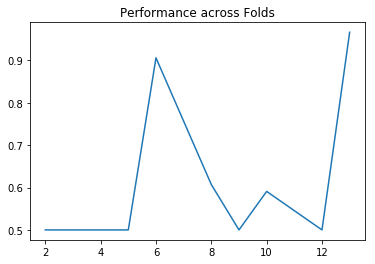

In [627]:
import matplotlib.pyplot as plt
print("Standard Deviation:", np.std(score_list))
print(indices)
plt.figure()
plt.plot(indices, score_list)
plt.title('Performance across Folds')
plt.show()

Which features are important during the time when the datasets are accurate?

In [622]:
indices = [x for x in range(len(score_list)) if score_list[x] > 0.5]
importance = np.array([])
count = 0

for idx in range(0, len(trainDataPartition)): # for several months of 2012, May - end of November, 1180, 1281
    # run random forest
    try:

        X_train, y_train = trainDataPartition[idx][:,1:data_size[1]+1], trainDataPartition[idx][:,0]
        y_train = y_train.astype('int')

        X_test, y_test = valDataPartition[idx][:,1:data_size[1]+1], valDataPartition[idx][:,0]
        y_test = y_test.astype('int')
    
        # Fit the RF model
        clf = RandomForestClassifier(n_estimators=50, max_depth=1500, random_state=0) # previously 7
        clf.fit(X_train, y_train)

        # print predicitions
        pred = clf.predict(X_test)
    
        if not importance.any():
            print('hi')
            importance = clf.feature_importances_
        else:
            importance = importance + clf.feature_importances_

        count+=1
    except:
        continue #np.nan

    try:
        temp_score = sklearn.metrics.roc_auc_score(y_test, pred)
        score_list.append(temp_score)
        indices.append(idx)
        print(temp_score)
    except:
        pass

hi
0.5
0.5
0.6278683574879227
0.43846153846153846
0.477984496124031
0.6505347593582887
0.6960281488549618
0.5837662337662337
0.6801318267419963
0.5624649859943978


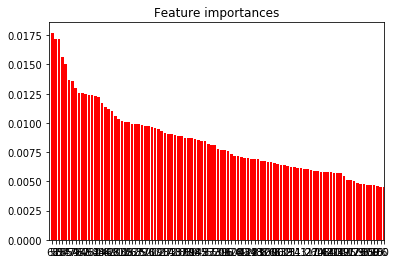

In [623]:
importance = importance / count
feature_indices = np.argsort(importance)[::-1]

# Plot the feature importances of the forest (ERROR HIDDEN, TOO BIG)
plt.figure()
plt.title("Feature importances")
plt.bar(range(X_train.shape[1]), importance[feature_indices],
       color="r", align="center") # X_train.shape[1]
plt.xticks(range(X_train.shape[1]), feature_indices) #X_train.shape[1]
plt.xlim([-1, 100]) #X_train.shape[1]]) 
plt.show()

In [624]:
name = 'Combined_Sets_from_Revised.csv'
df = pd.read_csv(name)
df = df.drop(['Date'], axis = 1)

# Show all the list of features and their respective importances

#listoffeatures = list(train_pd)[1:]
listoffeatures = list(df)
shortlist = []

print('Top Features listed by Importance')

for i in range(len(feature_indices)-1):
    idx = feature_indices[i]
    print(listoffeatures[idx], importance[idx])
    if i <= 25:
        shortlist.append(listoffeatures[idx])
shortlist

Top Features listed by Importance
main66 0.01771802655437917
main56 0.017216389089184953
main11 0.01718502566022472
main55 0.0156319172671174
main83 0.01506957276142824
main45 0.013631889426268326
main52 0.0135830793888044
main76 0.012966428382288472
main91 0.012544347301383842
main65 0.012539537333908918
main46 0.012469927570847032
main21 0.012399784829479314
main62 0.012373070426099586
main1 0.012311701506773036
main26 0.01225009329088286
gfp3 0.011674160245792039
gfp0 0.011339472753259435
main60 0.011178911127064636
main67 0.01101040856901028
main6 0.010618302891349546
main79 0.010365869174626282
main8 0.010185390061044668
main30 0.01008085444991896
main16 0.0100424544216107
main51 0.00993981391252402
main61 0.009905445343241209
main23 0.009866091142429076
main77 0.009839078855291901
main50 0.009771597276241576
main74 0.009722419072519929
Label_Regress 0.009650725774720445
main15 0.009535841581713634
main10 0.009449034547213084
main89 0.009269167234875638
main25 0.009120233112075984

['main66',
 'main56',
 'main11',
 'main55',
 'main83',
 'main45',
 'main52',
 'main76',
 'main91',
 'main65',
 'main46',
 'main21',
 'main62',
 'main1',
 'main26',
 'gfp3',
 'gfp0',
 'main60',
 'main67',
 'main6',
 'main79',
 'main8',
 'main30',
 'main16',
 'main51',
 'main61']

# Feature Importance

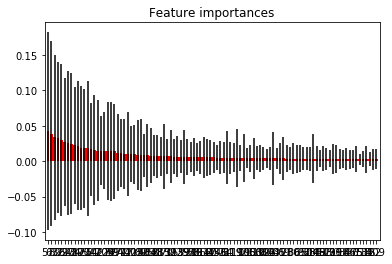

In [32]:
# Create a graph of fetaure importances

import matplotlib.pyplot as plt

importances = clf.feature_importances_
std = np.std([tree.feature_importances_ for tree in clf.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

# Plot the feature importances of the forest (ERROR HIDDEN, TOO BIG)
plt.figure()
plt.title("Feature importances")
plt.bar(range(100), importances[indices[0:100]],
       color="r", yerr=std[indices[0:100]], align="center") # X_train.shape[1]
plt.xticks(range(100), indices[0:100]) #X_train.shape[1]
plt.xlim([-1, 100]) #X_train.shape[1]]) 
plt.show()

In [33]:
print(len(clf.feature_importances_))
print(len(list(train_pd)[1:]))

217
218


In [36]:
name = '../Data/Combined_Sets_from_Revised_3.csv'
df = pd.read_csv(name)
df = df.drop(['Date'], axis = 1)

In [37]:
# Show all the list of features and their respective importances

#listoffeatures = list(train_pd)[1:]
listoffeatures = list(df)
shortlist = []

print('Top Features listed by Importance')

for i in range(len(indices)-1):
    idx = indices[i]
    print(listoffeatures[idx], importances[idx])
#    if i <= 50:
#        shortlist.append(listoffeatures[i])

Top Features listed by Importance
main56 0.04246516422174906
main66 0.038890888318713866
main81 0.03352209371117746
main31 0.03316343824589267
main71 0.029538007701172927
main61 0.027638836562973338
main96 0.026174527778898057
main41 0.024717976602409993
main33 0.022179143584261544
main86 0.02192126337972254
google_hits40 0.018536965272188975
main26 0.018094151121507362
main51 0.017907962611983155
main53 0.01662669776174378
main46 0.015511696529390826
main6 0.015034778619333933
invest5 0.014968034625538185
google_hits53 0.014830217360014095
main28 0.01446104855036105
main36 0.013716114196511751
main48 0.01369902198463893
main93 0.012202968050008907
main76 0.011880261213021217
main73 0.010328238974565888
main16 0.010052793341765304
main19 0.009764406723616902
invest3 0.009464639641187931
main11 0.00859702479350911
main88 0.008526362192154482
main39 0.008260623177502284
main24 0.008066004010519183
main82 0.007844714248476117
gfp8 0.007815534136366665
main87 0.007041696130779015
google_hi

# SVM

In [376]:
trainDataPartition, valDataPartition, group = time_cross(train, 0, 410, 260) #10 252 100 Draft_Google_shorter 0.8795

Last set: 6700 7110
410 259
410 259
410 259
410 259
410 259
410 259
410 259
410 259
410 259
410 259
410 7
Number of groups: 11 11


In [377]:
test = pd.DataFrame(valDataPartition[1])

In [416]:
splits = group
score_list = []
good_sets = []
gammas = []
indices = []

data_size = trainDataPartition[0].shape

for idx in range(len(trainDataPartition)-1):
    try:
        # print("TRAIN:", train_index, "TEST:", test_index)
        X_train, y_train = trainDataPartition[idx][:,1:data_size[1]+1], trainDataPartition[idx][:,0]
        y_train = y_train.astype('int')
        #print(X_train)
        X_test, y_test = valDataPartition[idx][:,1:data_size[1]+1], valDataPartition[idx][:,0]
        y_test = y_test.astype('int')
        print('train:', sum(y_train), len(y_train))
        print('test:', sum(y_test), len(y_test))
        #print(1 / (X_train.shape[1] * X_train.var()))
        # Fit the RF model

        #gamma =  (1 / (X_train.shape[1] * X_train.var()))
        clf = sklearn.svm.SVC(C=.7, kernel='rbf', gamma='scale') # previously 7
        clf.fit(X_train, y_train)
        
        
        # print predicitions
        pred = clf.predict(X_test)
        #print(pred)
    except:
        continue

    # add up AUROCs
            
    try:
        temp_score = sklearn.metrics.roc_auc_score(y_test, pred)
        score_list.append(temp_score)
        indices.append(idx)
        print(temp_score)
        if temp_score > 0.7:
            good_sets.append(idx)
            gammas.append(1 / (X_train.shape[1] * X_train.var()))
    except:
        pass


# calculate average
score = np.mean(score_list)
print("Averaged Score is: %0.4f" % score, splits)

train: 192 339
test: 107 190
0.5106406936155837
train: 194 343
test: 137 259
train: 192 340
test: 146 259
0.5695538853194326
train: 190 336
test: 103 182
0.6136782598009094
train: 183 323
test: 141 250
0.5682217450712473
train: 227 402
test: 114 202
0.5013955342902712
train: 174 307
test: 130 259
0.5
train: 193 342
test: 83 146
0.46270797475616754
train: 200 354
test: 132 259
0.5570269625387735
train: 190 336
test: 110 195
0.5
Averaged Score is: 0.5315 11


Standard Deviation: 0.045042820127822264
[0, 2, 3, 4, 5, 6, 7, 8, 9]


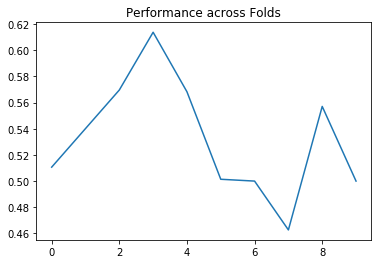

In [417]:
import matplotlib.pyplot as plt
print("Standard Deviation:", np.std(score_list))
print(indices)
plt.figure()
plt.plot(indices, score_list)
plt.title('Performance across Folds')
plt.show()

In [ ]:
good_sets

In [ ]:
pred_labels2 = []
for predlist in pred_labels:
    for x in range(len(predlist)):
        pred_labels2.append(predlist[x])
pred_labels2

# Test just one giant set
Why: Because if we can get more than 50%, we can get predictions for everything in the training set. Let's see if we can get some kind of "universal" model

In [614]:
file1 = "Combined_Sets_from_Revised.csv" #"Draft_Google_Shorter.csv" #Removed Missing

train_pd = pd.read_csv(file1)
train_pd.shape

(7120, 219)

In [615]:
train_pd = train_pd[6184:]

train = np.array(train_pd)
train.shape

(936, 219)

In [683]:
valDataPartition[7]

array([[1.0, 786.5599980000001, 2.908, ..., 0.0, 0.0, 26.0],
       [1.0, 789.5, 2.891, ..., 0.0, 0.0, 26.0],
       [1.0, 783.119995, 2.944, ..., 0.0, 0.0, 26.0],
       ...,
       [1.0, 683.849976, 1.9669999999999999, ..., 1.0, 1.0, 36.0],
       [1.0, 705.049988, 1.9580000000000002, ..., 1.0, 1.0, 36.0],
       [1.0, 706.179993, 1.996, ..., 1.0, 1.0, 36.0]], dtype=object)

# Random Forest Regressor

In [628]:
def simple_time_cross(array, time_shift = 0, size_train_set = 365, size_val_set = 100, set_shift = 0):
    np.random.seed(100)
    label_idx = 0

    if time_shift == 0:
        time_shift = size_train_set + size_val_set + set_shift
        
    train_size = train.shape
    j = 0
    group = 1
    end = train_size[0]
    trainDataPartition = [] # list
    valDataPartition = []

    #print(size_train_set, size_val_set, train_size[0])
    while j + (size_train_set + size_val_set + set_shift) < train_size[0]:
        trainset = []
        valset = []

        trainset = train[j:j+size_train_set, :] # array
        valset = train[j+size_train_set+1+set_shift:j+size_train_set+size_val_set+set_shift, :]

        trainDataPartition.append(trainset)
        valDataPartition.append(valset)
    
        group = group+1;
        j = j + time_shift


    # make last set -- decide if you want to throw out or adjust this set
    print('Last set:', j, j+size_train_set)
    trainset = train[j:j+size_train_set, :]
    valset = train[j+size_train_set+1+set_shift:end, :]
    #print(trainset)
    #print(valset)
    
    trainDataPartition.append(trainset)
    valDataPartition.append(valset)

    group = len(trainDataPartition)
    group_val = len(valDataPartition)
    print('Number of groups:', group, group_val)
    
    return trainDataPartition, valDataPartition, group

In [466]:
train_pd = train_pd.dropna() # drop any nan rows
train = np.array(train_pd)
train = train[:, :149] # drop google columns
#train = train[5902:, :]
train

array([['7/7/14', 1197.449951, 1, ..., 1281.75, 1264.5, 1269.0],
       ['7/8/14', 1194.689941, 1, ..., 1264.5, 1269.0, 1282.0],
       ['7/9/14', 1194.689941, 1, ..., 1269.0, 1282.0, 1310.0],
       ...,
       ['2/20/19', 1711.869995, 1, ..., 1312.95, 1322.5, 1320.75],
       ['2/21/19', 1711.869995, 1, ..., 1322.5, 1320.75, 1311.0],
       ['2/22/19', 1728.430054, 1, ..., 1320.75, 1311.0, 1314.0]],
      dtype=object)

In [467]:
labels = train[:,1]
train = train[:, 3:train.shape[1]]

In [468]:
labels = labels.reshape((train.shape[0], 1))

In [469]:
train = train.T

PCA

In [470]:
from sklearn.decomposition import PCA

pca = PCA(n_components=10)
pca.fit(train)  
PCA(copy=True, iterated_power='auto', n_components=2, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)
pca.explained_variance_ratio_

array([9.96791159e-01, 2.97488590e-03, 1.14740772e-04, 3.75600137e-05,
       1.59717217e-05, 1.19723578e-05, 9.01698145e-06, 6.86243466e-06,
       5.50895147e-06, 4.00229514e-06])

In [471]:
train2 = pca.components_
train2.shape
train = train2.T
train = np.concatenate((labels, train), axis = 1)

In [472]:
train.shape

(1167, 11)

In [476]:
[trainDataPartition, valDataPartition, group] = simple_time_cross(train, 0, 410, 100, 30)

Last set: 1080 1490
Number of groups: 3 3


Random Forest Regression

In [477]:
from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics

train: 494782 410
test: 125224 99


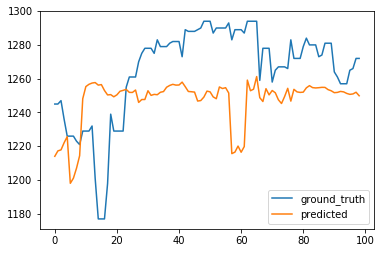

Mean Squared Error: 1119.1477026064933
-0.47838320729670825
train: 605392 410
test: 163722 99


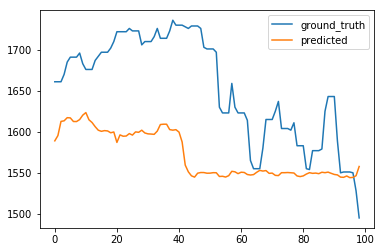

Mean Squared Error: 9141.293420722783
-1.3037992326817296
Averaged Score is: -0.8911 3


In [492]:
splits = group
score_list = []
good_sets = []
gammas = []
indices = []

data_size = trainDataPartition[0].shape

for idx in range(len(trainDataPartition)-1):
    try:
        # print("TRAIN:", train_index, "TEST:", test_index)
        X_train, y_train = trainDataPartition[idx][:,1:data_size[1]+1], trainDataPartition[idx][:,0]
        y_train = y_train.astype('int')
        #print(X_train)
        X_test, y_test = valDataPartition[idx][:,1:data_size[1]+1], valDataPartition[idx][:,0]
        y_test = y_test.astype('int')
        print('train:', sum(y_train), len(y_train))
        print('test:', sum(y_test), len(y_test))
        #print(1 / (X_train.shape[1] * X_train.var()))
        # Fit the RF model

        #gamma =  (1 / (X_train.shape[1] * X_train.var()))
        clf = RandomForestRegressor(max_depth = 20, n_estimators=1500, random_state=4, criterion = 'mse') # previously 7
        clf.fit(X_train, y_train)
        
        
        # print predicitions
        pred = clf.predict(X_test)
        #print(pred)

        plt.plot(y_test, label = 'ground_truth')
        plt.plot(pred, label = 'predicted')
        plt.legend()
        plt.show()
        print('Mean Squared Error:', metrics.mean_squared_error(y_test, pred))
        # add up AUROCs
    except:
        continue
            
    #try:
    #SS_tot = sum((y_test - np.mean(y_test))**2)
    #S_res = sum((y_test - pred) ** 2)
    #temp_score = 1 - (SS_res / SS_tot)
    temp_score = sklearn.metrics.r2_score(y_test, pred)
    score_list.append(temp_score)
    indices.append(idx)
    print(temp_score)
    if temp_score > 0.7:
        good_sets.append(idx)
        gammas.append(1 / (X_train.shape[1] * X_train.var()))
    #except:
    #    pass


# calculate average
score = np.mean(score_list)
print("Averaged Score is: %0.4f" % score, splits)

A plot by itself

Mean Squared Error: 9933.617003367


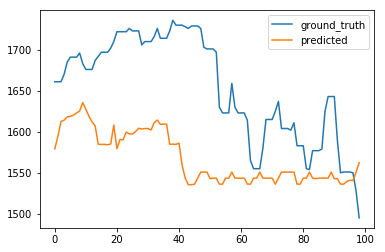

In [480]:
plt.plot(y_test, label = 'ground_truth')
plt.plot(pred, label = 'predicted')
plt.legend()
print('Mean Squared Error:', metrics.mean_squared_error(y_test, pred))

In [191]:
X_test[:,95]

array([1580.73999, 1597.709961, 1617.47998, 1608.459961, 1615.689941,
       1625.420044, 1658.699951, 1653.869995, 1637.22998], dtype=object)

In [183]:
trainDataPartition[0]

array([[204.53999299999998, 176.259995, 8.02, ..., 388.5, 390.4, 395.35],
       [204.53999299999998, 173.199997, 8.13, ..., 390.4, 395.35, 398.0],
       [208.28999299999998, 172.779999, 8.16, ..., 395.35, 398.0, 403.7],
       ...,
       [235.94999700000002, 233.07000699999998, 6.76, ..., 351.15, 349.3,
        350.3],
       [235.440002, 234.36000099999998, 6.71, ..., 349.3, 350.3, 351.75],
       [234.82000699999998, 232.289993, 6.78, ..., 350.3, 351.75, 356.65]],
      dtype=object)